# Notebook for training PLiNK on Newer College Dataset 

In [1]:
#load requirements for working with PCs
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import tensorflow as tf

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 10*1024 #22*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from scipy.spatial.transform import Rotation as R
import copy

from matplotlib import pyplot as p
from nerf_utils import *
from coarse_network_utils import*

%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

2024-10-16 11:03:00.724337: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 11:03:01.410312: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 11:03:02.657638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/lib:
2024-10-16 11:03:02.657816: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7:

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Autosaving every 180 seconds


### Generate Training Data from LiDAR Frames 
# TODO-- add ICET as git submodule

In [ ]:
# # Load ICET algorithm for point cloud registration 
# #   (provided ground truth poses are not sufficently accurat)
# current = os.getcwd()
# parent_directory = os.path.dirname(current)
# sys.path.append(parent_directory)
# sys.path.append(parent_directory+"/point_cloud_rectification")
# from ICET_spherical import ICET
# from linear_corrector import LC

### Alternatively, load pre-processed training data directly 

In [2]:
#Full loop of Courtyard
images = np.load("/home/derm/Desktop/imagesUndistortedV7.npy")
poses = np.load("/home/derm/Desktop/posesUndistortedV7.npy")
rays_o_all = np.load("/home/derm/Desktop/rays_oUndistortedV7.npy")
rays_d_all = np.load("/home/derm/Desktop/rays_dUndistortedV7.npy")

## Train fine network first for a warm start before jointly training two networks together

2024-10-16 11:03:16.500383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 11:03:16.501435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-16 11:03:16.501754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-16 11:03:16.502151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

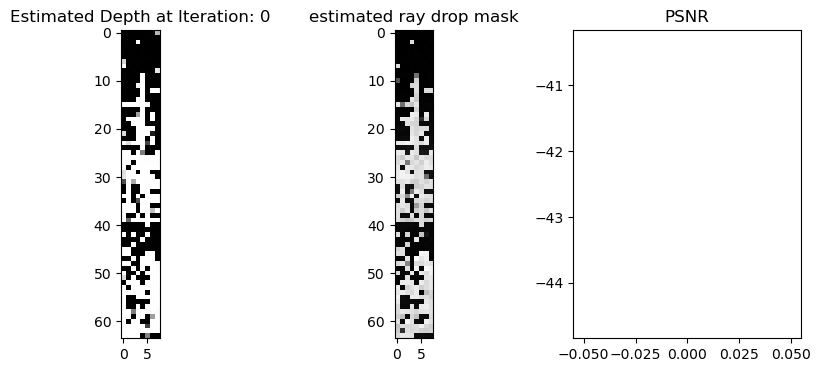

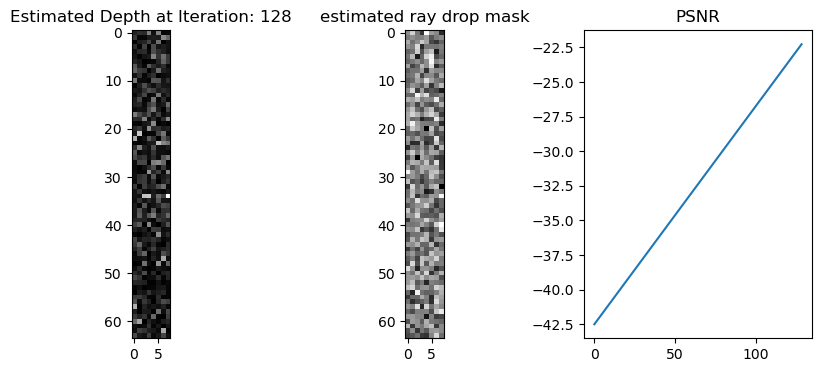

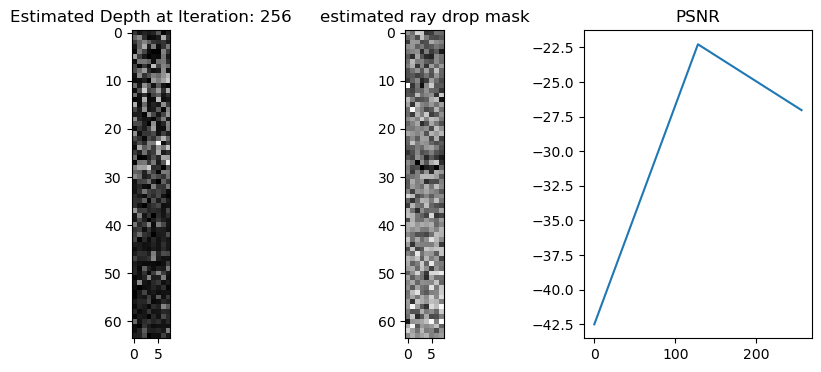

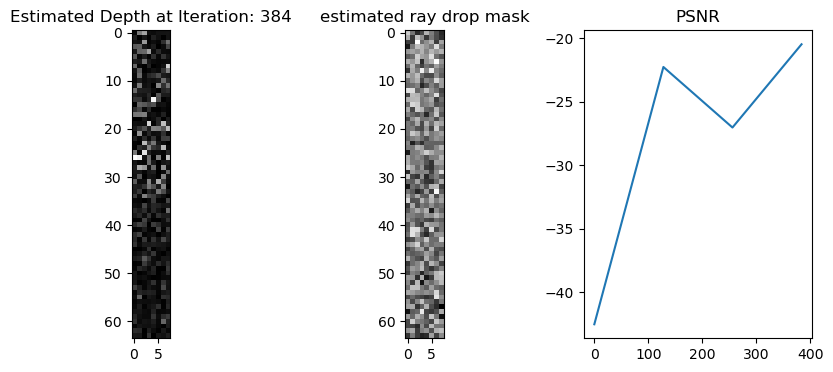

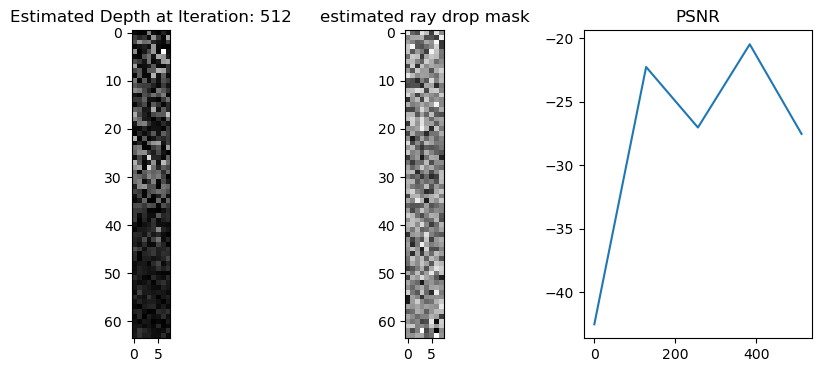

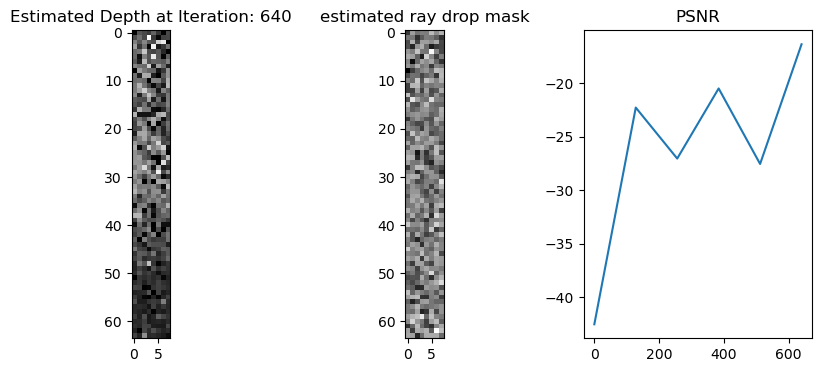

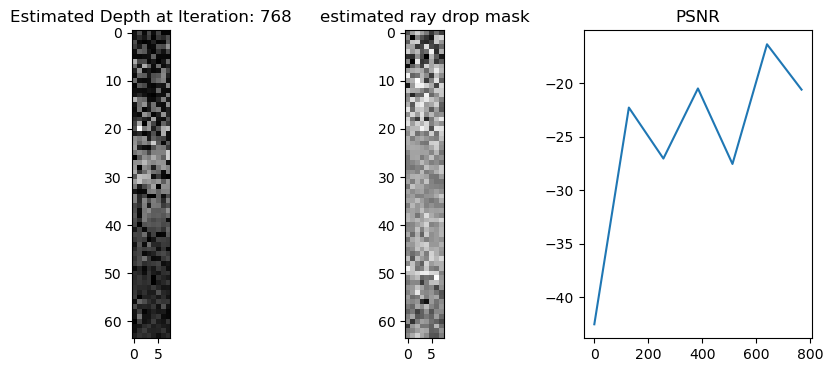

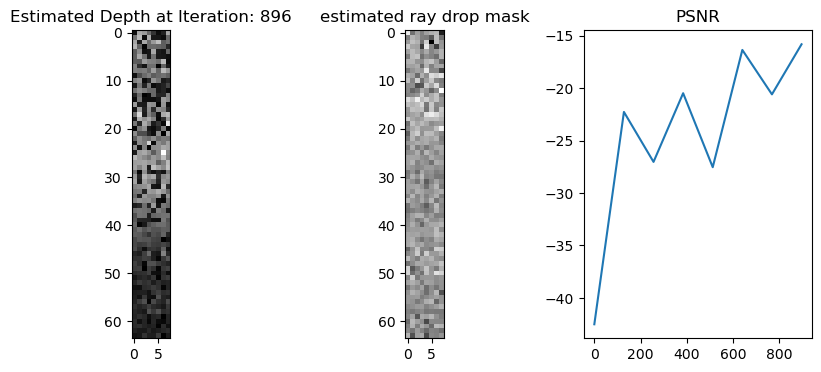

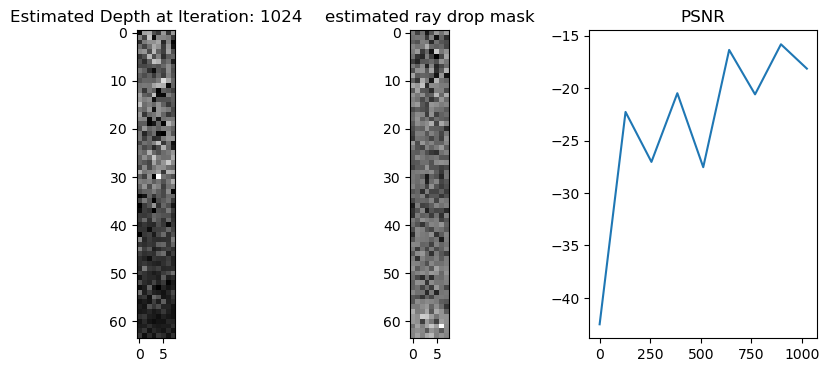

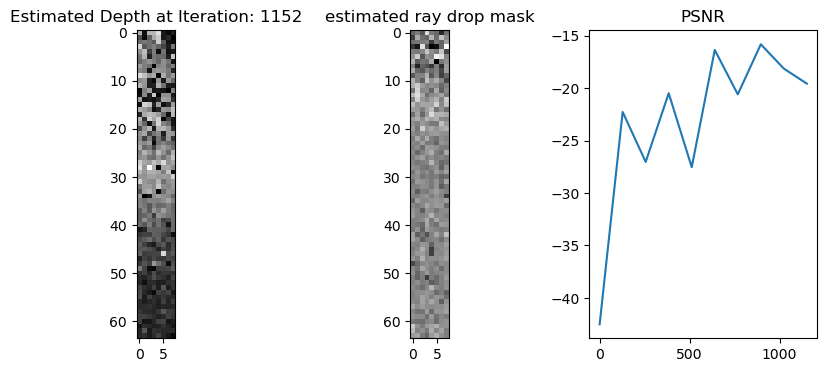

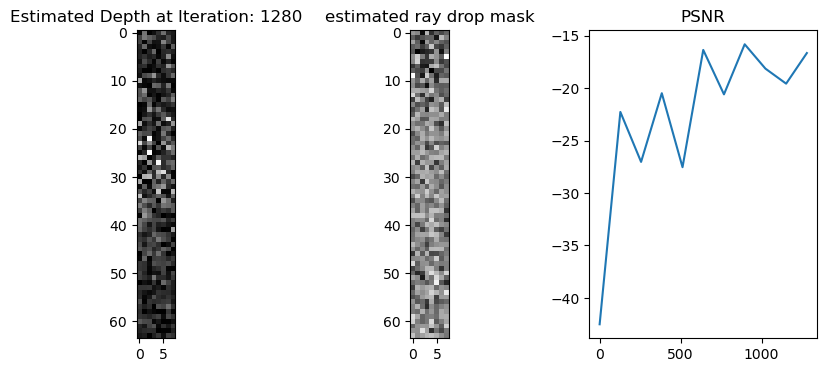

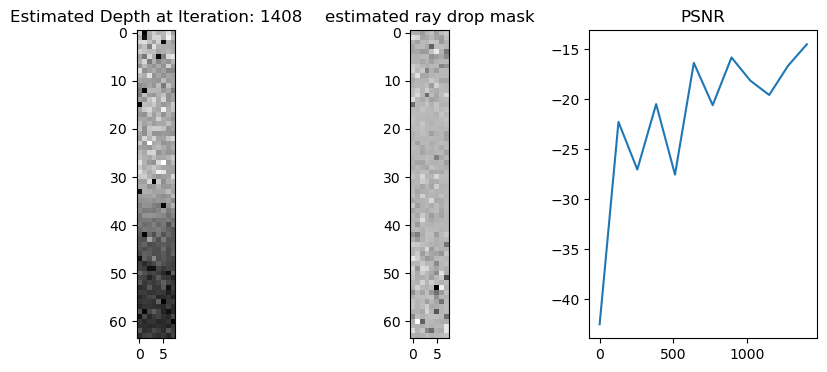

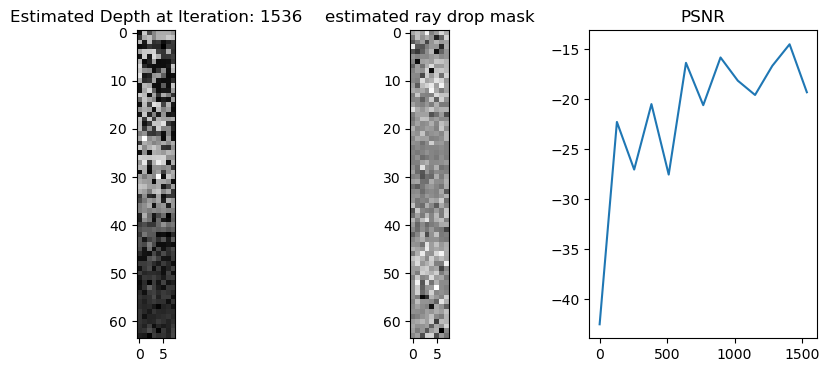

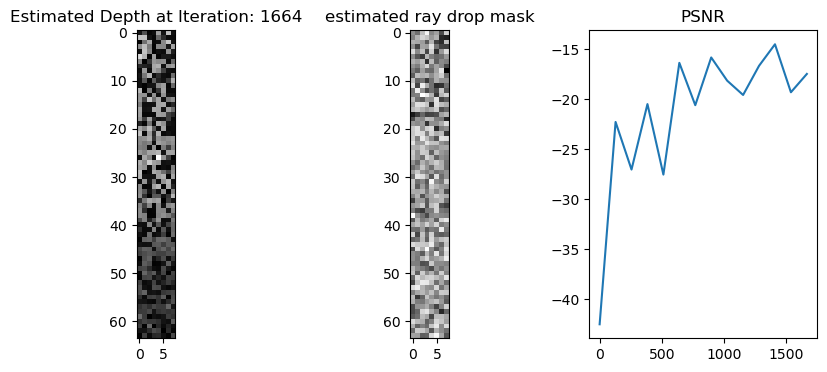

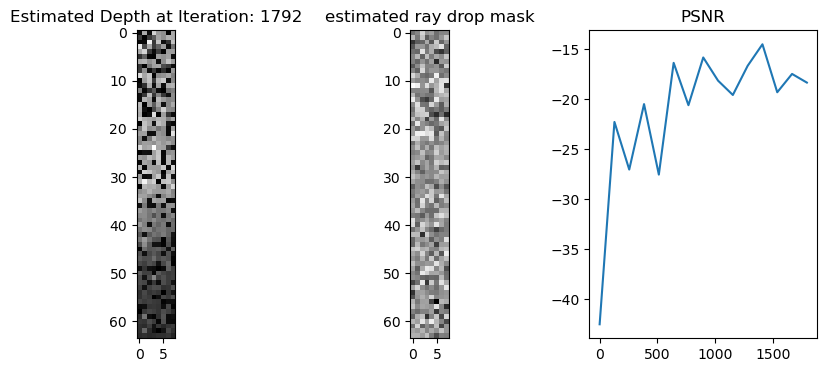

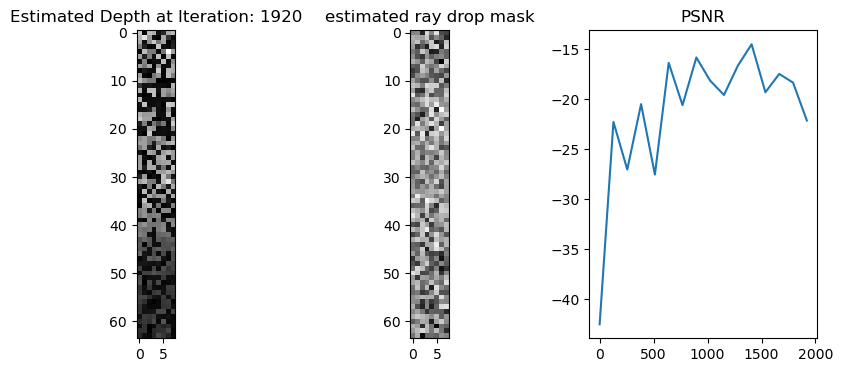

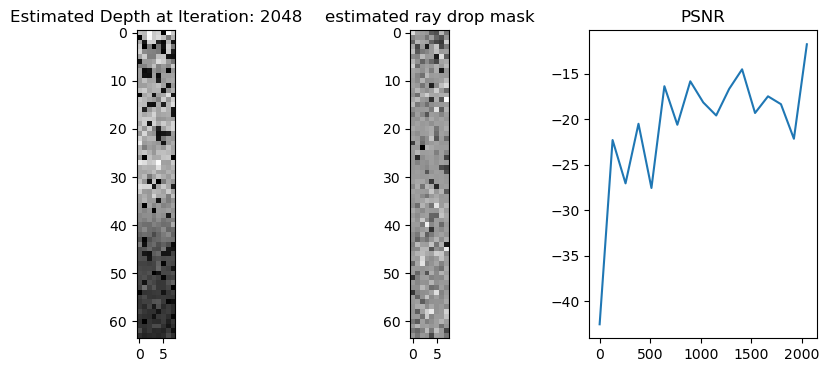

KeyboardInterrupt: 

In [3]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4) #default tiny-NeRF

N_samples = 128 #128 #256
near=0.
far= 1.
N_iters = 5_000_000
psnrs = []
iternums = []
i_plot = 128
accumulate_gradients_steps = 1 #32

n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax (at time of data generation)
H = 64 // n_vert_patches
W = 1024 // n_rots
testimg = images[12]
testpose = poses[12]

#actual upper and lower elevation limits of LiDAR sensor -- ignore the values in the Ouster OS1 Spec sheet!!
phimin = np.deg2rad(-15.594) #observed in raw data 
phimax = np.deg2rad(17.743) #observed in raw data

vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)  
phivals = np.linspace(phimin, phimax, 64)
gradients = [tf.zeros_like(var) for var in model.trainable_variables]
accumulated_loss = 0.0

for i in range(N_iters+1):
    img_i = np.random.randint(images.shape[0])

    target = images[img_i,:,:,:1]
    target_drop_mask = images[img_i,:,:,1:]
    pose = poses[img_i]
    rays_d = rays_d_all[img_i]
    rays_o = rays_o_all[img_i]
    
    with tf.GradientTape() as tape:

        # run coarse network~~~~~~~~~~~~~~~~~
        z_vals = tf.linspace(near, far, N_samples)  #z_vals must be in ascending order 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None] #manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        gtCDF = z_vals[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)

        loss = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF)

        #prevent NaN gradients from crashing training routine
        current_gradients = tape.gradient(loss, model.trainable_variables)
        current_gradients = [grad if grad is not None else tf.zeros_like(var) for grad, var in zip(current_gradients, model.trainable_variables)]
        gradients = [grad_accum + current_grad for grad_accum, current_grad in zip(gradients, current_gradients)]        
        accumulated_loss += loss
    
    if i%accumulate_gradients_steps==0:    
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        accumulated_loss = 0.0
        gradients = [tf.zeros_like(var) for var in model.trainable_variables]
        accumulated_loss = 0
    
    if i%i_plot==0:
        rays_o, rays_d = get_rays(H, W, testpose, vertical_bins[-2], vertical_bins[-1]) #constant validation image
        z_vals = tf.linspace(near, far, N_samples) 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]
        depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        target = testimg[:,:,:1]
        target_drop_mask = testimg[:,:,1:]
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        iternums.append(i)
        p.figure(figsize=(10,4))
        p.subplot(131)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
        p.subplot(133)
        p.plot(iternums, psnrs)
        p.title('PSNR')
        p.subplot(132)
        p.imshow(ray_drop, cmap="gray")#, norm = 'log')
        p.title("estimated ray drop mask")
        p.show()
print('Done')

#### Reproduce first training scan using fine network

In [4]:
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True)
disp=[]

N_samples = 128
n_cols_to_skip = n_rots // 8 #mimic trainig data where researcher blocks large portion of frame
for j in range(n_rots * n_vert_patches - 2*n_cols_to_skip*n_vert_patches):
    idx = j + 20*(n_rots - 2*n_cols_to_skip)
    
    pose = poses[idx]
    rays_d = rays_d_all[idx]
    rays_o = rays_o_all[idx]
    
    z_vals = tf.linspace(near, far, N_samples) 
    z_vals += 1.0*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    z_vals = z_vals[:,:,:,None]
    
    depth, ray_drop, CDF, weights = render_rays(model, rays_o, rays_d,  z_vals)
    
    new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
    depth = tf.transpose(depth).numpy()
    depth = np.flip(depth, axis = 0)
    
    #scale back up to normal size (positional encoding requires all points scaled [0,1])
    depth *= 200 
    ray_drop = tf.transpose(ray_drop).numpy()
    ray_drop = np.flip(ray_drop, axis = 0)
    
    count = 0
    for w in range(W):
        for h in range(H):
            #draw all points
#             new_point_cloud_spherical[count,0] = depth[w,h] #radius 
            # suppress ray dropped points
            if ray_drop[w,h] > 0.9:             
                    new_point_cloud_spherical[count,0] = depth[w,h] #radius
            else:
                    new_point_cloud_spherical[count,0] = 0 
            new_point_cloud_spherical[count,1] = (w-(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/(H - 1))  
            count+= 1

    new_point_cloud_spherical[:,1] -= (np.pi/n_rots) + j*(2*np.pi/n_rots) + np.pi
    new_point_cloud_spherical[:,2] -= (phimax+phimin)
    
    new_point_cloud_cart = spherical_to_cartesian(new_point_cloud_spherical).numpy() 
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z for visualization

    disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3, alpha = 0.5))
    
plt.show(disp, "Reproducing first training scan using single network")
ViewInteractiveWidget(plt.window)   

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Train Dual Networks

2024-10-16 11:05:20.035508: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-10-16 11:05:20.037667: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-10-16 11:05:20.037687: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-10-16 11:05:20.037767: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:34

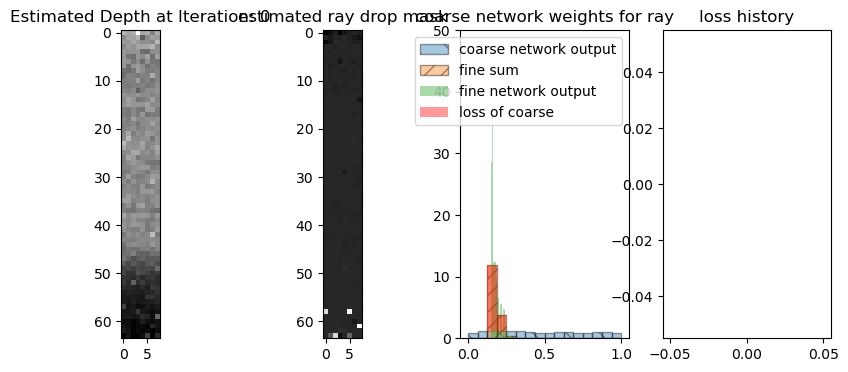

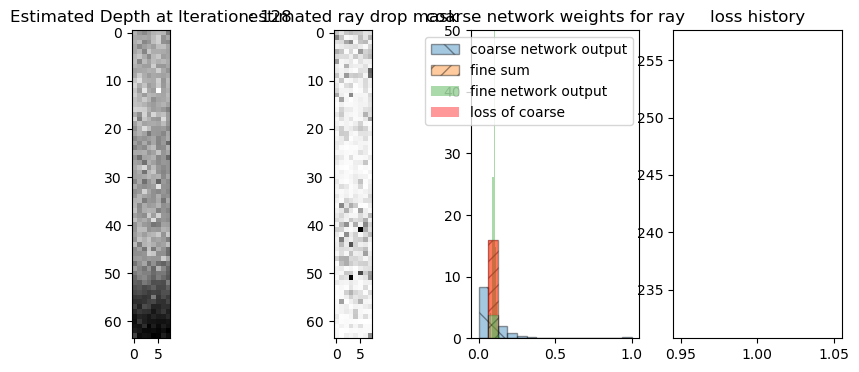

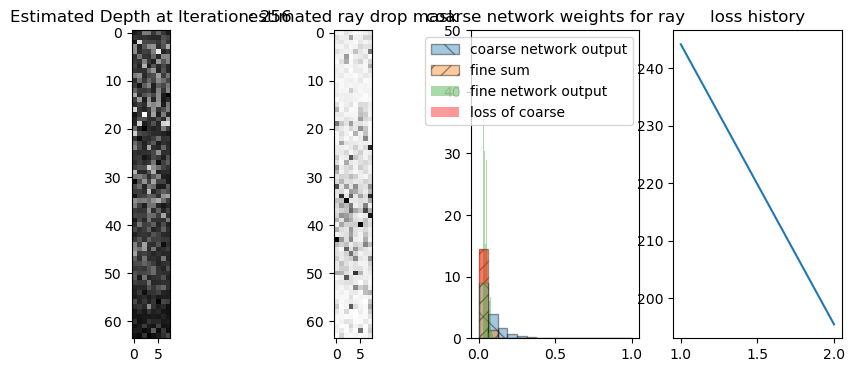

KeyboardInterrupt: 

In [5]:
# from nerf_utils import *

model_coarse = init_model_proposal()
model_fine = init_model()
model_fine = model #warm start from previous training loop
loss_hist = np.zeros([0])

#1e-4 -> 1e-6
optimizer_coarse = tf.keras.optimizers.Adam(1e-4)
#1e-4 -> 1e-6
optimizer_fine = tf.keras.optimizers.Adam(1e-4)

n_bins_fine = 128 #512 
n_bins_coarse = 16 #64
near=0.
far=1.
N_iters = 10_000
psnrs = []
iternums = []
i_plot = 128 #256

n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #8 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots
vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)  
phivals = np.linspace(phimin, phimax, 64)#new (correct) way to bin elevation angles

loss_since_last_plot = np.zeros([0])
for i in range(N_iters):
    img_i = np.random.randint(images.shape[0])

    #use full vertical span of patch
    target = images[img_i,:,:,:1]
    target_drop_mask = images[img_i,:,:,1:]
    pose = poses[img_i]
    rays_d = rays_d_all[img_i]
    rays_o = rays_o_all[img_i]
        
#     # break up scans vertically at train time -- do this as needed to prevent OOM errors
#     # make sure to drop the LR proportionally!
#     patch_height = 16
#     vert_crop_start = np.random.randint(0,H - patch_height - 1)
#     vert_crop_end = vert_crop_start + patch_height
#     target = images[img_i,vert_crop_start:vert_crop_end,:,:1]
#     target_drop_mask = images[img_i,vert_crop_start:vert_crop_end,:,1:]
#     pose = poses[img_i]
#     rays_d = rays_d_all[img_i, vert_crop_start:vert_crop_end]
#     rays_o = rays_o_all[img_i, vert_crop_start:vert_crop_end]
    
    idx_first=len(phivals) - (img_i%(n_vert_patches))*(64//n_vert_patches)-1
    idx_second= (len(phivals)- ((img_i+1)%(n_vert_patches))*(64//n_vert_patches))%len(phivals)
    phimin_patch = phivals[idx_first]
    phimax_patch = phivals[idx_second]

    with tf.GradientTape() as tape_coarse, tf.GradientTape() as tape_fine:
        #run coarse network first to get locations to evaluate fine model at ~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
        z_vals_coarse += 0.0*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
        z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        #move z vals coarse to center of histogram bins 
        width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
        width_coarse = tf.concat([width_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
        z_vals_coarse = z_vals_coarse + width_coarse/2

        z_vals_fine, width_fine, weights_coarse = run_coarse_network(model_coarse, z_vals_coarse, width_coarse, 
                                                                     rays_o, rays_d, n_resample = n_bins_fine)
        z_vals_fine = z_vals_fine[:, :, :, None]
        weights_coarse = weights_coarse[:, :, :, None]
                
        # run fine network to get actual scene density ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~        
        depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        gtCDF = z_vals_fine[:,:,:,0] > target[:,:,:]
        gtCDF = tf.cast(gtCDF, tf.float32)
        
        #weights of zero will produce zero area, leading to NaN loss        
        epsilon = 1e-6
        padded_area_by_bin = (weights_fine + epsilon*tf.ones_like(width_fine)) * width_fine #slightly closer?
        area_fine = tf.reduce_sum(padded_area_by_bin, axis=2, keepdims=True)       
        weights_fine /= area_fine

        #per advice of mip-nerf 360, calculate fine losss first then apply gradient stop
        # so that the fine network doesn't dumb itslef down to appease coarse loss function
        loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask, CDF = CDF, gtCDF = gtCDF)
        weights_fine_stopped = tf.stop_gradient(weights_fine)
        loss_coarse, fine_sum = calculate_loss_coarse_network(z_vals_coarse[:,:,:,0], 
                                                                z_vals_fine[:,:,:,0], 
                                                                weights_coarse[:,:,:,0], 
                                                                weights_fine_stopped, 
                                                                width_coarse[:,:,:,0],
                                                                width_fine[:,:,:],
                                                                debug = True)
        loss_coarse = tf.math.reduce_sum(loss_coarse)
        gradients_fine = tape_fine.gradient(loss_fine, model_fine.trainable_variables)
        optimizer_fine.apply_gradients(zip(gradients_fine, model_fine.trainable_variables))        
        gradients_coarse = tape_coarse.gradient(loss_coarse, model_coarse.trainable_variables)
        optimizer_coarse.apply_gradients(zip(gradients_coarse, model_coarse.trainable_variables))


    if i % i_plot == 0:
        loss_hist = np.append(loss_hist, np.mean(loss_since_last_plot))
        loss_since_last_plot = np.zeros([0])
        
        #rescale weights_coarse before plotting
        eps = 1e-3
        weights_coarse = weights_coarse + eps*tf.ones_like(weights_coarse)
        weights_coarse = weights_coarse/ tf.math.reduce_sum(width_coarse*weights_coarse, axis = 2)[:,:,None]
        mask = tf.cast(fine_sum > weights_coarse[:,:,:,0], tf.float32)
        L_along_ray = mask * (fine_sum - weights_coarse[:,:,:,0]) * width_coarse[:,:,:,0]

        look_at = 0
        p.figure(figsize=(10,4))
        p.subplot(141)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
        p.subplot(143)
        p.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], width=width_coarse[look_at,0,:,0],
             alpha = 0.4, label = 'coarse network output', hatch = '\\', edgecolor = 'black')
        p.bar(z_vals_coarse[look_at,0,:,0], fine_sum[look_at,0,:], width=width_coarse[look_at,0,:,0],
             alpha = 0.4, label = 'fine sum', hatch = '//', edgecolor = 'black')
        p.bar(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:], width=width_fine[look_at,0,:],
             alpha = 0.4, label= 'fine network output')
        p.bar(z_vals_coarse[look_at,0,:,0], L_along_ray[look_at,0,:]/width_coarse[look_at,0,:,0], width=width_coarse[look_at,0,:,0],
              bottom = weights_coarse[look_at,0,:,0], alpha = 0.4, color = 'red', 
              label= 'loss of coarse')    
        p.ylim([0,50])
        p.title('coarse network weights for ray')
        p.legend(loc="best")
        p.subplot(142)
        p.imshow(ray_drop, cmap="gray")#, norm = 'log')
        p.title("estimated ray drop mask")
        p.subplot(144)
        p.title("loss history")
        p.plot(loss_hist)
        p.show()
    else:
        loss_since_last_plot = np.append(loss_since_last_plot, loss_fine)

# Use the two networks to generate a point cloud at a novel frame 

In [6]:
num_view = 64 #128 #number of (rotational?) patches to draw
n_bins_coarse = 32 #32
n_bins_fine = 128 #1024 #2048 #512 #256

start_frame_idx = 100 #320 #100 #20
start_idx = start_frame_idx*(128 - 2*n_cols_to_skip)

near=0.
far= 1.
n_rots = 64 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax

H = 64 // n_vert_patches
W = 1024 // n_rots
# phimin = np.deg2rad(-15.593) #observed in raw data
# phimax = np.deg2rad(17.743)
phimax = np.deg2rad(15.593) #test -- might actually look better at render time?
phimin = np.deg2rad(-17.743)

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
savepc = np.zeros([0,3]) #to save point cloud to external file

very_beginning = time.time()

for j in range(num_view):
    print(j,"/",num_view)

    #get sensor transformation matrix
    rotm = poses[start_idx].copy()

    #center in courtyard dataset
    rotm[:3,-1] = np.array([5., 55., -13.])/200
    #center in forest dataset -- startidx = 320
    #rotm[:3,-1] += np.array([25., 5, 0.])/200

    # account for image crop in rotation
    crop_angle =  -(3*np.pi/n_rots) - j*(2*np.pi/n_rots) #test
    rotm_crop = R.from_euler('xyz', [0,0,-crop_angle + 3*np.pi/4]).as_matrix() 
    rotm[:3,:3] = rotm[:3,:3] @ rotm_crop
    rotm = rotm.astype(np.float32)
    vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
    phimin_patch = vertical_bins[img_i%n_vert_patches] 
    phimax_patch = vertical_bins[img_i%n_vert_patches + 1]
    
    #RUN COARSE NETWORK
    rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
    z_vals_coarse = tf.linspace(near, far - (far/n_bins_coarse), n_bins_coarse)  #IMPORTANT NOTE: z_vals must be in ascending order 
    z_vals_coarse += 0.00*tf.random.uniform(list(rays_o.shape[:-1]) + [n_bins_coarse]) * (far-near)/n_bins_coarse
    z_vals_coarse = z_vals_coarse[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
    #move z vals coarse to center of histogram bins 
    width_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis=2)
    width_coarse = tf.concat([width_coarse, 1.- z_vals_coarse[:,:,-1][:,:,None] ], axis=2)    
    z_vals_coarse = z_vals_coarse + width_coarse/2
    z_vals_fine, width_fine, weights_coarse = run_coarse_network(model_coarse, z_vals_coarse, width_coarse, 
                                                                 rays_o, rays_d, n_resample = n_bins_fine)   
    eps = 1e-3
    weights_coarse_scaled = weights_coarse + eps*tf.ones_like(weights_coarse)
    weights_coarse_scaled = weights_coarse_scaled[:,:,:,None]/ tf.math.reduce_sum(width_coarse*weights_coarse_scaled[:,:,:,None], axis = 2)[:,:,None]
    z_vals_fine = z_vals_fine[:, :, :, None]
    weights_coarse = weights_coarse[:, :, :, None]
        
    #RUN FINE NETWORK
    depth, ray_drop, CDF, weights_fine = render_rays(model_fine, rays_o, rays_d,  z_vals_fine, 
                                                     roll_override = 0.1)    
    
    #CONVERT OUTPUT TO POINT CLOUD IN CORRECT FRAME
    new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
    depth = tf.transpose(depth).numpy()
    depth = np.flip(depth, axis = 0)
    #scale back up to true size
    depth *= 200
    ray_drop = tf.transpose(ray_drop).numpy()
    ray_drop = np.flip(ray_drop, axis = 0)
    count = 0
    for w in range(W):
        for h in range(H):
#             new_point_cloud_spherical[count,0] = depth[w,h] #radius #draw all points
            if ray_drop[w,h] > 0.95:             
                    new_point_cloud_spherical[count,0] = depth[w,h] #radius
            else:
                    new_point_cloud_spherical[count,0] = 0#100 # suppress ray dropped points
            new_point_cloud_spherical[count,1] = (w+(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)   #was this
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/(H - 1)) #[17.74,-15.59] #(correct)       
            count+= 1
    new_point_cloud_spherical[:,1] -= -j*(2*np.pi/n_rots)
    new_point_cloud_spherical[:,2] -= (phimax+phimin)    
    new_point_cloud_cart = spherical_to_cartesian(new_point_cloud_spherical).numpy()
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2]
    savepc = np.append(savepc, new_point_cloud_cart, axis = 0)
    disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3, alpha = 0.5))

plt.show(disp, "Coarse to Fine PLiNK Rendering")
ViewInteractiveWidget(plt.window)

0 / 64
1 / 64
2 / 64
3 / 64
4 / 64
5 / 64
6 / 64
7 / 64
8 / 64
9 / 64
10 / 64
11 / 64
12 / 64
13 / 64
14 / 64
15 / 64
16 / 64
17 / 64
18 / 64
19 / 64
20 / 64
21 / 64
22 / 64
23 / 64
24 / 64
25 / 64
26 / 64
27 / 64
28 / 64
29 / 64
30 / 64
31 / 64
32 / 64
33 / 64
34 / 64
35 / 64
36 / 64
37 / 64
38 / 64
39 / 64
40 / 64
41 / 64
42 / 64
43 / 64
44 / 64
45 / 64
46 / 64
47 / 64
48 / 64
49 / 64
50 / 64
51 / 64
52 / 64
53 / 64
54 / 64
55 / 64
56 / 64
57 / 64
58 / 64
59 / 64
60 / 64
61 / 64
62 / 64
63 / 64


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)